In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler

from general_utils import *

%matplotlib inline


In [ ]:
base_dir='YOUR_BASE_DIR_HERE'
save_dir = 'YOUR_SAVE_DIR_HERE'

###### if not already generated, run generate_and_save_mappings from general_utils.py
fpath = base_dir+'ensembl2symbol.pkl'
with open(fpath, 'rb') as f:
    map_e2s = pickle.load(f)
    map_s2e = pickle.load(f)


###### if counts files have not been generated, run run_bam_processing or process_bam_to_tsv from general_utils.py
###### Read back in UMI counts
umi_counts = pd.read_csv(base_dir+'umi_counts_1k_overall.tsv', sep='\t', header=None)
umi_counts.columns = ['UMI', 'count']

######### cleaned umis tsv file
cleaned_umis = pd.read_csv(base_dir+'cleaned_umis_1k.tsv', sep='\t').rename(columns={'UB':'UMI'})


In [ ]:
malat1_ensg = map_s2e['MALAT1']
umi_counts_malat1 = cleaned_umis[cleaned_umis['GX'] == malat1_ensg]['UMI'].value_counts().reset_index()
umi_counts_rest = cleaned_umis[cleaned_umis['GX'] != malat1_ensg]['UMI'].value_counts().reset_index()

In [ ]:
########### if running from scratch, need to run and regenerate these files

# malat1_counts_df = process_umi_counts(umi_counts_malat1, extend_to_full=True, k=12)
# rest_counts_df = process_umi_counts(umi_counts_rest, extend_to_full=True, k=12)

# malat1_PWM = compute_PWM(malat1_counts_df)
# all_but_MALAT1_PWM = compute_PWM(rest_counts_df)


# intermediary_file_dir='small_intermediary_files/'
# ######### save all 4 of these to a pkl file
# with open(intermediary_file_dir+'PWM_malat1.pkl', 'wb') as f:
#     pickle.dump(malat1_PWM, f)
# with open(intermediary_file_dir+'PWM_all_but_MALAT1.pkl', 'wb') as f:
#     pickle.dump(all_but_MALAT1_PWM, f)
# with open(intermediary_file_dir+'malat1_counts.pkl', 'wb') as f:
#     pickle.dump(malat1_counts_df, f)
# with open(intermediary_file_dir+'rest_counts.pkl', 'wb') as f:
#     pickle.dump(rest_counts_df, f)

######## read the 4 back in
intermediary_file_dir='small_intermediary_files/'

with open(intermediary_file_dir+'PWM_malat1.pkl', 'rb') as f:
    malat1_PWM = pickle.load(f)
with open(intermediary_file_dir+'PWM_all_but_MALAT1.pkl', 'rb') as f:
    all_but_MALAT1_PWM = pickle.load(f)
with open(intermediary_file_dir+'malat1_counts.pkl', 'rb') as f:
    malat1_counts_df = pickle.load(f)
with open(intermediary_file_dir+'rest_counts.pkl', 'rb') as f:
    rest_counts_df = pickle.load(f)


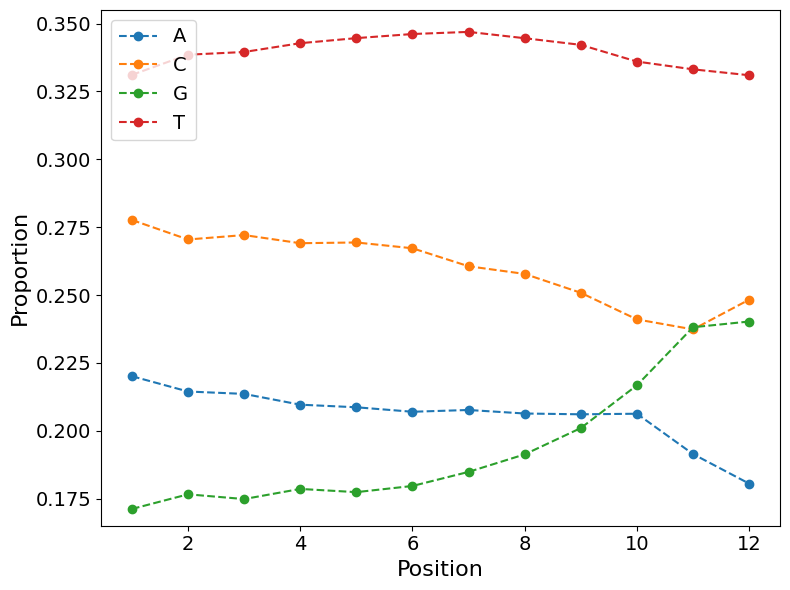

In [15]:
############# Figure generation for paper: fig:umi_pwm, and fig:umi_pwm_MALAT1

is_malat_1 = True

if is_malat_1:
    pfm = malat1_PWM
else:
    pfm = all_but_MALAT1_PWM


# Step 1: Prepare data for plotting
# We need to transpose the PFM so that positions are rows (for the x-axis)
pfm_to_plot = pfm.T

# The positions are 0-indexed, let's make them 1-indexed for the plot
pfm_to_plot.index = pfm_to_plot.index + 1

# Step 2: Create the plot
plt.figure(figsize=(8, 6))
ax= plt.gca()

# Step 3: Plot the proportion of each base at each position
pfm_to_plot.plot(
    ax=ax,
    linestyle='--',
    marker='o',
    xlabel="Position",
    ylabel="Proportion"
)

# Step 5: Final styling touches
# Move the legend outside of the plot area
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
# ax.set_title(ax.get_title(), fontsize=18)
plt.ylim((.165,.355))
# ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=14) ######## only save legend for MALAT1
plt.legend(loc="upper left", fontsize=14)

# Ensure x-axis ticks are integers
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Adjust layout to prevent the legend from being cut off
plt.tight_layout()

if is_malat_1:
    plt.savefig(save_dir+f'PWM_1k_MALAT1.pdf', bbox_inches='tight')
else:
    # plt.gca().legend_.remove()
    plt.savefig(save_dir+f'PWM_1k_all_but_MALAT1.pdf', bbox_inches='tight')

In [17]:
########## dummy dataframe with constant nucleotide frequencies across positions.
constant_PFM = np.outer(np.array([.23,.24,.21,.32]), np.ones(12))
constant_PFM_df = pd.DataFrame(constant_PFM, index=['A', 'C', 'G', 'T'], columns=range(12))

In [18]:
###### merge these two dfs, and then compute the theoretical probability based off of the "rest" PWM for each umi
merged_cts_df = pd.merge(malat1_counts_df[['UMI','count']], rest_counts_df[['UMI','count']], on='UMI', suffixes=('_malat1', '_rest'))
print('merged')
pfm = all_but_MALAT1_PWM
log_pfm = np.log(pfm + 1e-9)

log_pfm_const = np.log(constant_PFM_df + 1e-9)

# Step 2: Initialize a Series to store the accumulating log probability
# Start with zeros, since we will be adding to it.
final_log_probs = pd.Series(0.0, index=merged_cts_df.index)

final_log_probs_const = pd.Series(0.0, index=merged_cts_df.index)


# Step 3: Loop through each position and add its log probability
for position in tqdm(range(12)):
    # EFFICIENTLY get the base at the current position for ALL UMIs
    bases_at_pos = merged_cts_df['UMI'].str[position]

    # Map the corresponding log probabilities for that position
    log_probs_at_pos = bases_at_pos.map(log_pfm[position])

    # Add these to the total log probability
    final_log_probs += log_probs_at_pos

    # Do the same for the constant PFM
    log_probs_at_pos_const = bases_at_pos.map(log_pfm_const[position])
    final_log_probs_const += log_probs_at_pos_const

# Step 4: Assign the final result to your DataFrame
merged_cts_df['theory_prob'] = np.exp(final_log_probs)
merged_cts_df['theory_prob_const'] = np.exp(final_log_probs_const)

merged


100%|██████████| 12/12 [01:45<00:00,  8.75s/it]


In [19]:
merged_cts_df['prob_malat1'] = merged_cts_df['count_malat1'] / merged_cts_df['count_malat1'].sum()
merged_cts_df['prob_rest'] = merged_cts_df['count_rest'] / merged_cts_df['count_rest'].sum()


merged_cts_df['num_ts'] = merged_cts_df.UMI.str.count('T')
merged_cts_df['num_as'] = merged_cts_df.UMI.str.count('A')
merged_cts_df['num_cs'] = merged_cts_df.UMI.str.count('C')
merged_cts_df['num_gs'] = merged_cts_df.UMI.str.count('G')
merged_cts_df['num_trailing_ts'] = merged_cts_df['UMI'].str.extract(r'(T*)$')[0].str.len()

######## groupby number of trailing Ts, and sum empirical and theoretical probabilities
grouped_by_trailing_ts = merged_cts_df.groupby('num_trailing_ts').agg({'prob_malat1': 'mean', 'prob_rest': 'mean', 'theory_prob': 'mean', 'theory_prob_const': 'mean'})


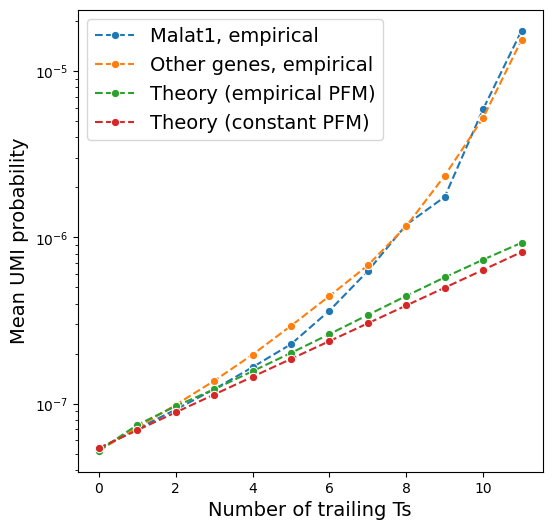

In [20]:
############# Figure generation for paper: fig:umi_trailing_t_probs

plt.figure(figsize=(6, 6))
sns.lineplot(data=grouped_by_trailing_ts, x=grouped_by_trailing_ts.index, y='prob_malat1', label='Malat1, empirical', linestyle='--', marker='o')
sns.lineplot(data=grouped_by_trailing_ts, x=grouped_by_trailing_ts.index, y='prob_rest', label='Other genes, empirical', linestyle='--', marker='o')
sns.lineplot(data=grouped_by_trailing_ts, x=grouped_by_trailing_ts.index, y='theory_prob', label='Theory (empirical PFM)', linestyle='--', marker='o')
sns.lineplot(data=grouped_by_trailing_ts, x=grouped_by_trailing_ts.index, y='theory_prob_const', label='Theory (constant PFM)', linestyle='--', marker='o')
plt.legend()

plt.ylabel('Mean UMI probability', fontsize=14)
plt.xlabel('Number of trailing Ts', fontsize=14)
plt.legend(fontsize=14)
plt.yscale('log')
# plt.savefig(save_dir+'/umi_trailing_t_probs_malat1.pdf', bbox_inches='tight')


In [29]:


merged_cts_df['empirical_freq'] = merged_cts_df['count_rest'] / merged_cts_df['count_rest'].sum()

# Define the two main groups of data based on the 'count' column
cts_thresh = 20
df_to_sample = merged_cts_df[merged_cts_df['count_rest'] <= cts_thresh]
df_to_keep = merged_cts_df[merged_cts_df['count_rest'] > cts_thresh]

# Group the first df by 'count' and sample each group.
# This single operation replaces your entire for loop.
df_sampled = df_to_sample.groupby('count_rest').apply(
    lambda x: x.sample(n=min(len(x), 10000), random_state=42)
).reset_index(drop=True)

# Combine the two parts just once at the end
filtered_df = pd.concat([df_to_keep, df_sampled])

/tmp/ipykernel_1756755/3464935657.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('count_rest').apply(


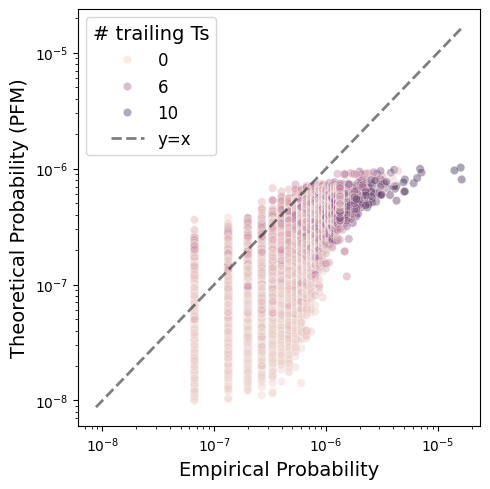

In [36]:
############# Figure generation for paper: fig:pwm_probs_12


k=12
plt.figure(figsize=(5,5))
sns.scatterplot(data=filtered_df, x='empirical_freq', y='theory_prob', hue='num_trailing_ts', alpha=0.4, hue_order=[0,k//2,(k-1)//2])
plt.xscale('log')
plt.yscale('log')
min_freq = filtered_df.theory_prob.min()
max_freq = max(filtered_df.theory_prob.max(), filtered_df.empirical_freq.max())
plt.plot([min_freq, max_freq], [min_freq, max_freq], color='black', linestyle='--', linewidth=2, label='y=x', zorder=10, alpha=.5)
plt.ylabel('Theoretical Probability (PFM)', fontsize=14)
plt.xlabel('Empirical Probability', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()

middle_index = len(labels) // 2
selected_indices = [0, middle_index, -2,-1]  # first, middle, last
new_handles = [handles[i] for i in selected_indices]
new_labels = [labels[i] for i in selected_indices]

plt.legend(
    new_handles,
    new_labels,
    title='# trailing Ts',
    title_fontsize=14,
    fontsize=12,
    loc="upper left"
)
plt.tight_layout()
plt.savefig(save_dir+'/umi_probs_theory_pwm_12.pdf')
plt.savefig(save_dir+'/umi_probs_theory_pwm_12.jpg')


In [ ]:
def generate_plot_umi_probabilities(merged_cts_df_reduced, k, save_dir, truncate_from_front=False):
    """
    Generate a scatter plot comparing empirical UMI probabilities (truncated to length k) to theoretical probabilities
    under a constant nucleotide model. By default, UMIs are truncated from the end.

    Parameters
    ----------
    merged_cts_df_reduced : pd.DataFrame
        DataFrame with at least columns ['UMI', 'empirical_freq'].
    k : int
        Length of UMI to consider.
    save_dir : str
        Directory to save the generated plot.
    truncate_from_front : bool, optional
        If True, truncate UMIs from the front (remove basepairs from the front); otherwise, from the end (default: False).
    """

    merged_cts_df_k = merged_cts_df_reduced.copy()
    if truncate_from_front: ### remove basepairs from front
        merged_cts_df_k['UMI'] = merged_cts_df_k['UMI'].str[-k:]
    else:
        merged_cts_df_k['UMI'] = merged_cts_df_k['UMI'].str[:k]

    merged_cts_df_k = merged_cts_df_k.groupby('UMI').agg({'empirical_freq': 'sum'}).reset_index()

    merged_cts_df_k['num_ts'] = merged_cts_df_k.UMI.str.count('T')
    merged_cts_df_k['num_as'] = merged_cts_df_k.UMI.str.count('A')
    merged_cts_df_k['num_cs'] = merged_cts_df_k.UMI.str.count('C')
    merged_cts_df_k['num_gs'] = merged_cts_df_k.UMI.str.count('G')
    merged_cts_df_k['num_trailing_ts'] = merged_cts_df_k['UMI'].str.extract(r'(T*)$')[0].str.len()


    nuc_probs = np.array([0.23, 0.24, 0.21, 0.32])  # rounded based on length 5 UMIs, ACGT


    nuc_counts = merged_cts_df_k[['num_as', 'num_cs', 'num_gs', 'num_ts']].values

    log_probs = np.dot(nuc_counts, np.log10(nuc_probs))
    merged_cts_df_k['log_prob_indep'] = log_probs
    merged_cts_df_k['theory_prob_const'] = 10 ** merged_cts_df_k['log_prob_indep']

    # Define the two main groups of data based on the 'count' column
    min_freq = merged_cts_df_k[merged_cts_df_k['empirical_freq']>0].empirical_freq.min()

    df_to_sample = merged_cts_df_k[merged_cts_df_k['empirical_freq'] <= 20*min_freq]
    df_to_keep = merged_cts_df_k[merged_cts_df_k['empirical_freq'] > 20*min_freq]

    # Group the first df by 'count' and sample each group.
    # This single operation replaces your entire for loop.
    df_sampled = df_to_sample.groupby('empirical_freq').apply(
        lambda x: x.sample(n=min(len(x), 10000), random_state=42)
    ).reset_index(drop=True)
        
    filtered_df = pd.concat([df_to_keep, df_sampled])

    plt.figure(figsize=(5,5))
    sns.scatterplot(data=filtered_df, x='empirical_freq', y='theory_prob_const', hue='num_trailing_ts', alpha=0.6)
    plt.xscale('log')
    plt.yscale('log')
    min_freq = filtered_df[filtered_df['empirical_freq']>0].empirical_freq.min()
    max_freq = filtered_df.empirical_freq.max()
    xRange = [min_freq/1.1,max_freq*1.1]
    plt.plot(xRange, xRange, color='black', linestyle='--', linewidth=2, label='y=x', zorder=10, alpha=.5)
    plt.ylabel('Theoretical Probability', fontsize=14)
    plt.xlabel('Empirical Probability', fontsize=14)

    handles, labels = plt.gca().get_legend_handles_labels()

    # Keep first, last and a middle entry. e.g. ['0', '2', '4', '6', '8', '10', 'y=x'] -> ['0', '4', '10', 'y=x']
    middle_index = len(labels) // 2
    selected_indices = [0, middle_index, -2,-1]  # first, middle, last
    new_handles = [handles[i] for i in selected_indices]
    new_labels = [labels[i] for i in selected_indices]

    plt.legend(
        new_handles,
        new_labels,
        title='# trailing Ts',
        title_fontsize=14,
        fontsize=12,
        loc="upper left"
    )
    
    plt.tight_layout()

    if truncate_from_front:
        save_name = save_dir+f'/umi_probs_theory_const_{k}_truncate_from_front'
    else:
        save_name = save_dir+f'/umi_probs_theory_const_{k}'
    plt.savefig(save_name + '.pdf')
    plt.savefig(save_name + '.jpg')
    plt.close()
    print(f"Success,saving plots to {save_name}")


/tmp/ipykernel_1756755/2564316979.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('empirical_freq').apply(


Success,saving plots to /data/tbaharav/umi_dylan/figs//umi_probs_theory_const_5


/tmp/ipykernel_1756755/2564316979.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('empirical_freq').apply(


Success,saving plots to /data/tbaharav/umi_dylan/figs//umi_probs_theory_const_5_truncate_from_front


/tmp/ipykernel_1756755/2564316979.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('empirical_freq').apply(


Success,saving plots to /data/tbaharav/umi_dylan/figs//umi_probs_theory_const_9


/tmp/ipykernel_1756755/2564316979.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('empirical_freq').apply(


Success,saving plots to /data/tbaharav/umi_dylan/figs//umi_probs_theory_const_9_truncate_from_front


/tmp/ipykernel_1756755/2564316979.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('empirical_freq').apply(


Success,saving plots to /data/tbaharav/umi_dylan/figs//umi_probs_theory_const_12


/tmp/ipykernel_1756755/2564316979.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('empirical_freq').apply(


Success,saving plots to /data/tbaharav/umi_dylan/figs//umi_probs_theory_const_12_truncate_from_front


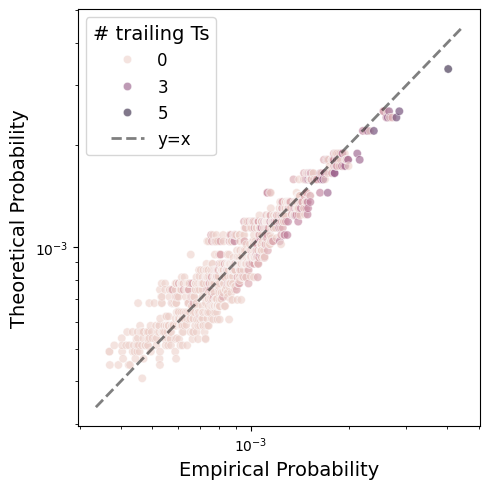

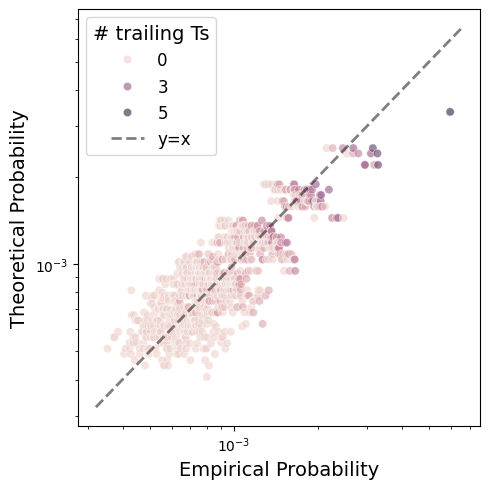

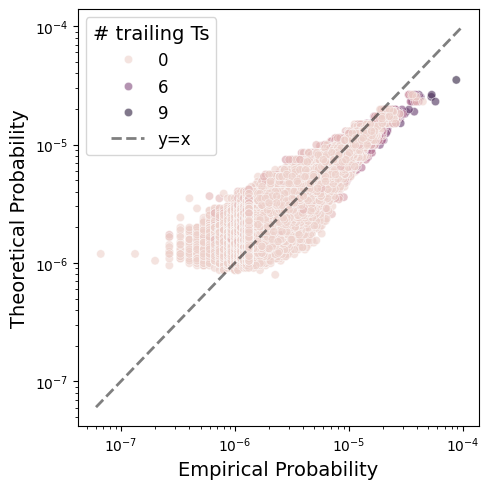

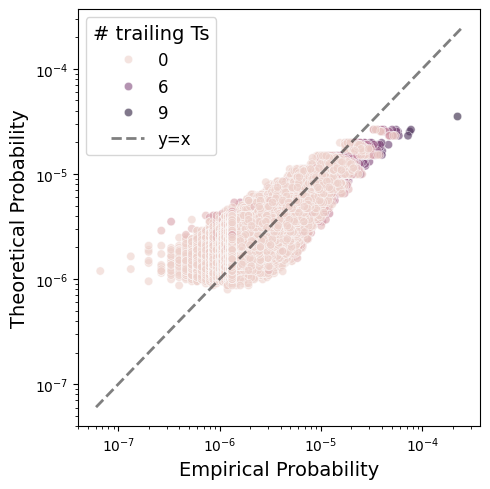

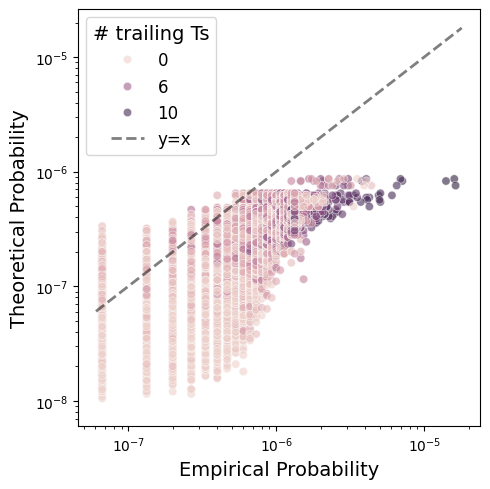

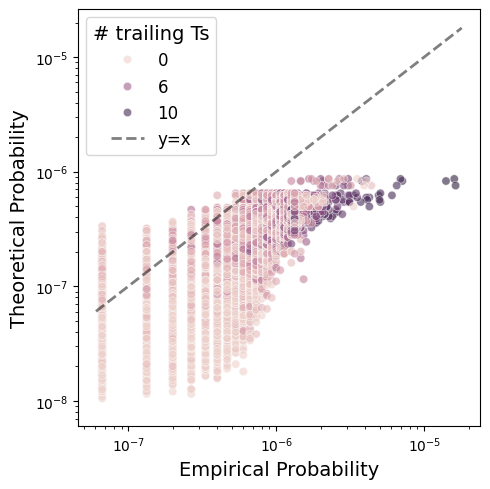

In [45]:
for k in [5, 9, 12]:
    for truncate_from_front in [False, True]:
        generate_plot_umi_probabilities(
            merged_cts_df[['UMI', 'empirical_freq']],
            k=k,
            save_dir=save_dir,
            truncate_from_front=truncate_from_front
        )

In [46]:

all_umi_df = rest_counts_df.copy()

# 1. Separate features (X) and target (y)
features = ['num_as', 'num_ts', 'num_cs', 'num_trailing_ts', 'num_trailing_ts_squared']
X = all_umi_df[features]
y = all_umi_df['count']

ts_counts = all_umi_df['num_trailing_ts'].value_counts()

# Create the weights series. Each UMI's weight is the inverse of its group's size.
# This up-weights rare observations.
weights = 1 / all_umi_df['num_trailing_ts'].map(ts_counts)

# Normalize weights to have a mean of 1 for stability (optional but good practice)
weights = weights / weights.mean()

# 2. (Optional but recommended) Scale features for better numerical stability
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Fit the model 
print("Fitting with scikit-learn's PoissonRegressor...")
poisson_skl = PoissonRegressor(alpha=0, 
                               tol=1e-6, 
                               max_iter=500, # Increase max iterations just in case
                               verbose=1)
poisson_skl.fit(X, y, sample_weight=weights)


# 4. View the results
print("\nModel fitting complete!")
print(f"Intercept: {poisson_skl.intercept_:.6f}")
print("\nCoefficients:")
# Note: These coefficients correspond to the SCALED features
for feature, coef in zip(features, poisson_skl.coef_):
    print(f"{feature}: {coef:.6f}")

Fitting with scikit-learn's PoissonRegressor...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

Model fitting complete!
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


Intercept: 0.231355

Coefficients:
num_as: 0.020850
num_ts: 0.598850
num_cs: 0.089224
num_trailing_ts: -0.230805
num_trailing_ts_squared: 0.087420
           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     60     76      1     0     0   6.159D-06  -1.203D+02

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [47]:

print("Generating predictions for all UMIs...")
predicted_counts = poisson_skl.predict(X)

# Add the predictions back to your dataframe for easy comparison
# This creates a new column named 'predicted_count'
prediction_df = all_umi_df.copy()
prediction_df['predicted_count'] = predicted_counts
print("Predictions added to the DataFrame.")
prediction_df['empirical_freq'] = prediction_df['count'] / prediction_df['count'].sum()

Generating predictions for all UMIs...
Predictions added to the DataFrame.


/tmp/ipykernel_1756755/2193987417.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_to_sample.groupby('empirical_freq').apply(


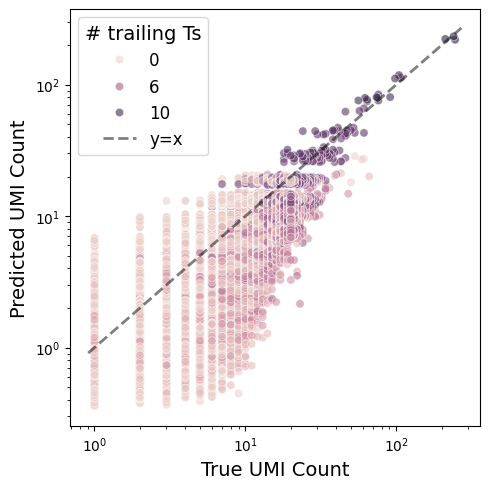

In [53]:
min_freq = prediction_df[prediction_df['empirical_freq']>0].empirical_freq.min()

df_to_sample = prediction_df[prediction_df['empirical_freq'] <= 20*min_freq]
df_to_keep = prediction_df[prediction_df['empirical_freq'] > 20*min_freq]

# Group the first df by 'count' and sample each group.
# This single operation replaces your entire for loop.
df_sampled = df_to_sample.groupby('empirical_freq').apply(
    lambda x: x.sample(n=min(len(x), 10000), random_state=42)
).reset_index(drop=True)
    
filtered_df = pd.concat([df_to_keep, df_sampled])

plt.figure(figsize=(5,5))
sns.scatterplot(data=filtered_df, x='count', y='predicted_count', hue='num_trailing_ts', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
min_ct = filtered_df[filtered_df['count']>0]['count'].min()
max_ct = filtered_df['count'].max()
xRange = [min_ct/1.1,max_ct*1.1]
plt.plot(xRange, xRange, color='black', linestyle='--', linewidth=2, label='y=x', zorder=10, alpha=.5)
plt.xlabel('True UMI Count', fontsize=14)
plt.ylabel('Predicted UMI Count', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()

# Keep first, last and a middle entry. e.g. ['0', '2', '4', '6', '8', '10', 'y=x'] -> ['0', '4', '10', 'y=x']
middle_index = len(labels) // 2
selected_indices = [0, middle_index, -2,-1]  # first, middle, last
new_handles = [handles[i] for i in selected_indices]
new_labels = [labels[i] for i in selected_indices]

plt.legend(
    new_handles,
    new_labels,
    title='# trailing Ts',
    title_fontsize=14,
    fontsize=12,
    loc="upper left"
)

plt.tight_layout()

plt.savefig(save_dir+'/umi_probability_prediction_trailing_ts.pdf', bbox_inches='tight')
### also save as jpg
plt.savefig(save_dir+'/umi_probability_prediction_trailing_ts.jpg', bbox_inches='tight')